### Exploring how to visualize inference performance
Some statistics we'll be able to look at:  
Time per prediction  
Total time (for n inputs)  
Number of correct/incorrect predictions  
???

In [38]:
from __future__ import print_function
import numpy as np
import math
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


###### First let's generate some phony data
Calling one FPGA and the other GPU for no real reason.

In [69]:
fpga_timing_measurements = [float(x)/624214 for x in np.random.randint(38, 42, 10000)]
fpga_total_time = float(sum(fpga_timing_measurements))
fpga_num_correct = 9872.0
fpga_pct_correct = fpga_num_correct/10000

gpu_timing_measurements = [float(x)/624214 for x in np.random.randint(6, 120, 10000)]
gpu_total_time = float(sum(gpu_timing_measurements))
gpu_num_correct = 9873.0
gpu_pct_correct = gpu_num_correct/10000

In [37]:
print(gpu_total_time)
print(fpga_total_time)

1.00210024126
0.633034504193


In [58]:
fpga_stddev = float(math.sqrt(np.var(fpga_timing_measurements)))
gpu_stddev = float(math.sqrt(np.var(gpu_timing_measurements)))
fpga_avg = float(fpga_total_time/10000)
gpu_avg = float(gpu_total_time/10000)

### Throughput comparison graph

<IPython.core.display.Javascript object>


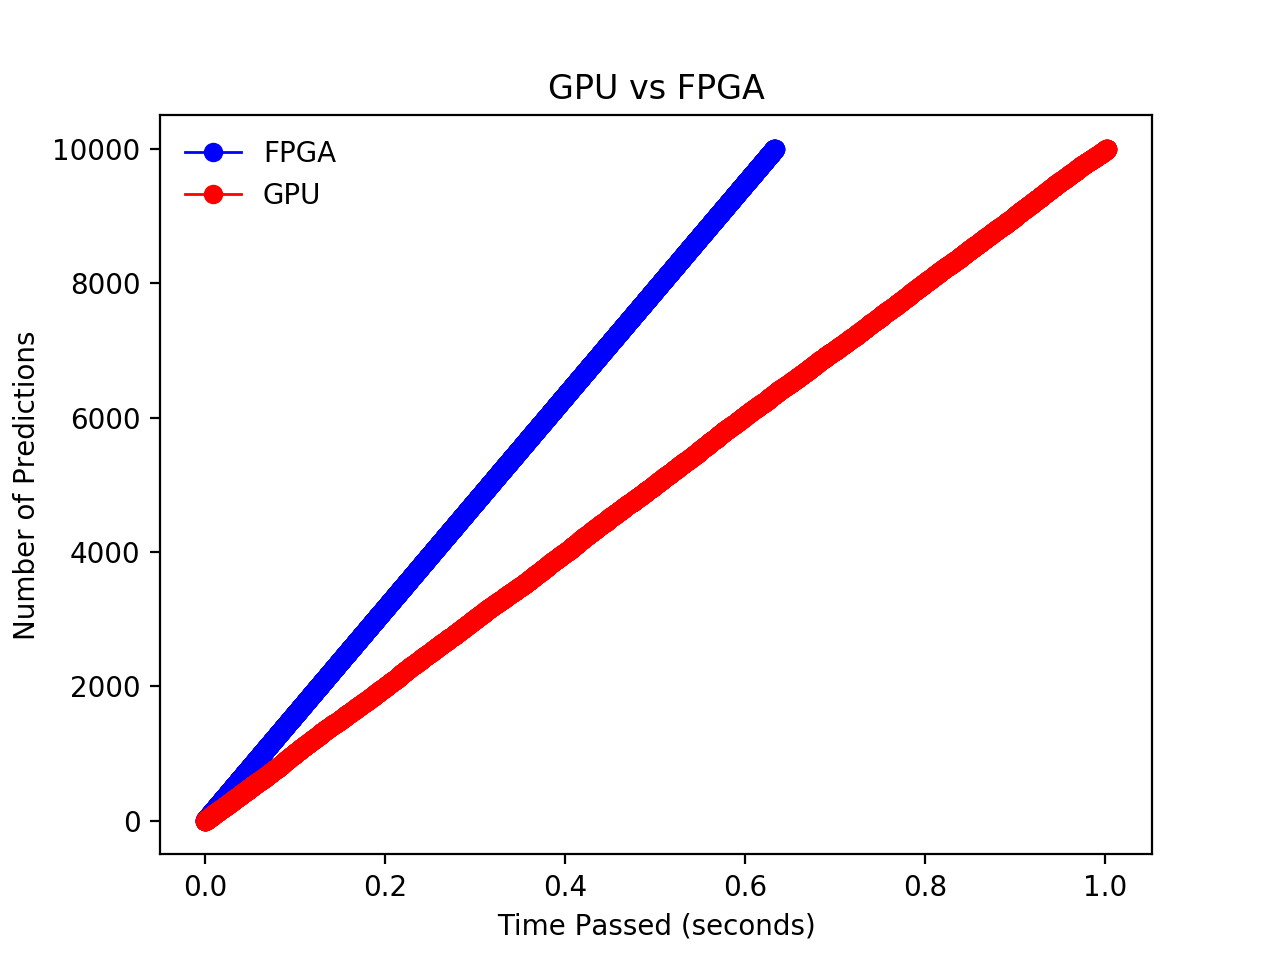

In [49]:
fpga_timing_useful = [sum(fpga_timing_measurements[0:x]) for x in range(0, 10000)]
gpu_timing_useful = [sum(gpu_timing_measurements[0:x]) for x in range(0, 10000)]
plt.figure()
plt.plot(fpga_timing_useful, range(1, 10001), '-o', color="blue", linewidth=1, linestyle="-", label="FPGA")
plt.plot(gpu_timing_useful, range(1, 10001), '-o', color="red", linewidth=1, linestyle="-", label="GPU")
plt.legend(loc='upper left', frameon=False)
plt.xlabel('Time Passed (seconds)')
plt.ylabel('Number of Predictions')
plt.title('GPU vs FPGA')
plt.show()

### Histgram next
The last graph wasn't too informative, how could I improve that?  

Let's move on to the histogram

<IPython.core.display.Javascript object>


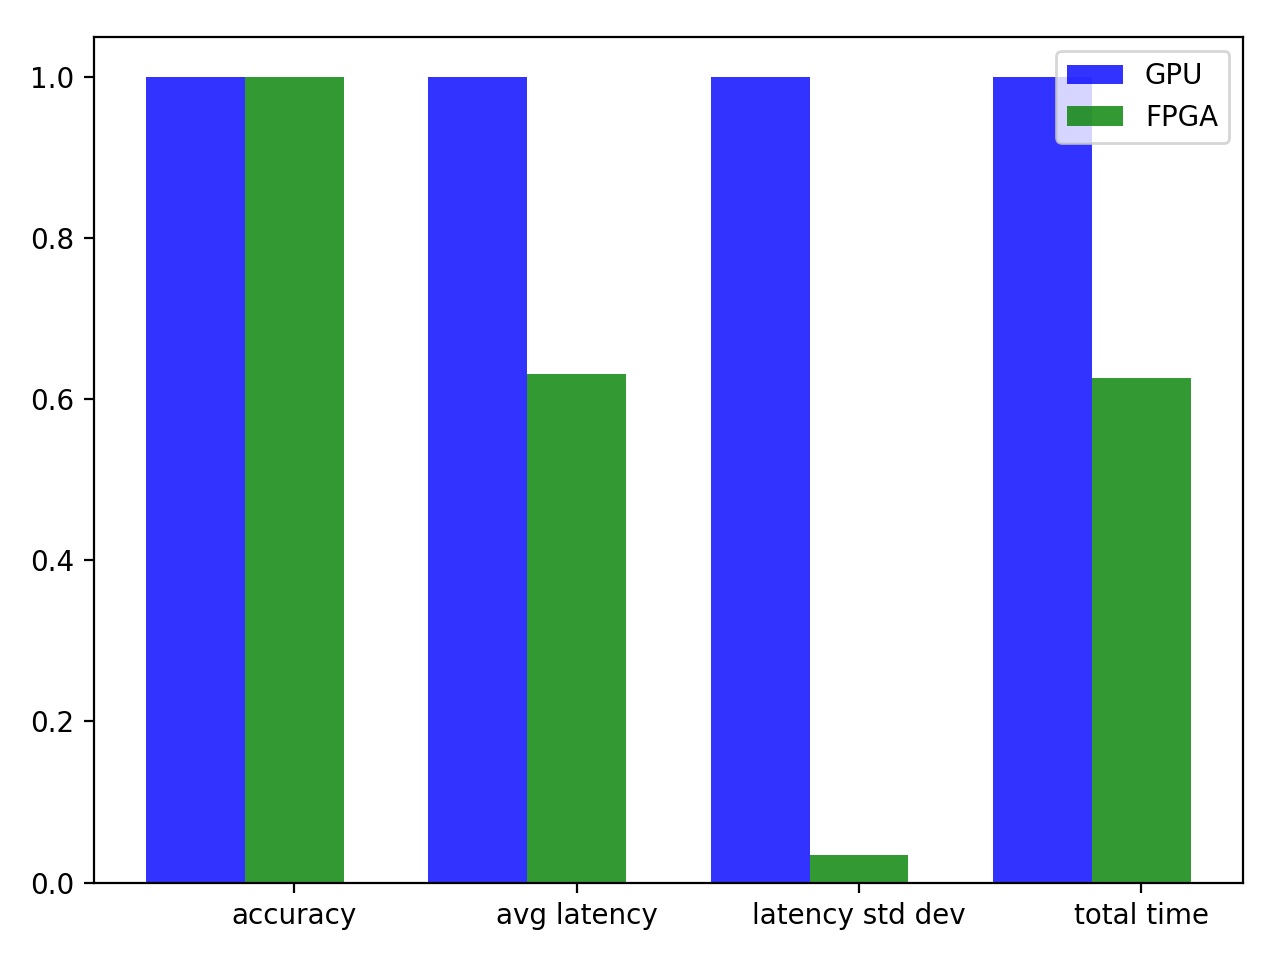

In [97]:
gpu_data = [gpu_pct_correct/max(fpga_pct_correct, gpu_pct_correct), gpu_avg/max(fpga_avg, gpu_avg),
                    gpu_stddev/max(fpga_stddev, gpu_stddev), gpu_total_time/max(fpga_total_time, gpu_total_time)]
fpga_data = [fpga_pct_correct/max(fpga_pct_correct, gpu_pct_correct), fpga_avg/max(fpga_avg, gpu_avg),
                    fpga_stddev/max(fpga_stddev, gpu_stddev), fpga_total_time/max(fpga_total_time, gpu_total_time)]

n_groups = 4
 
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, gpu_data, bar_width,
                 alpha=opacity,
                 color='b',
                 label='GPU')
 
rects2 = plt.bar(index + bar_width, fpga_data, bar_width,
                 alpha=opacity,
                 color='g',
                 label='FPGA')

#plt.hist([fpga_pct_correct/max(fpga_pct_correct, gpu_pct_correct), fpga_avg/max(fpga_avg, gpu_avg),
#                    fpga_stddev/max(fpga_stddev, gpu_stddev), fpga_total_time/max(fpga_total_time, gpu_total_time)], x, alpha=0.5, label='FPGA')
#plt.hist([gpu_pct_correct/max(fpga_pct_correct, gpu_pct_correct), gpu_avg/max(fpga_avg, gpu_avg),
#                    gpu_stddev/max(fpga_stddev, gpu_stddev), gpu_total_time/max(fpga_total_time, gpu_total_time)], x, alpha=0.5, label='GPU')
plt.xticks(index+bar_width, ['accuracy','avg latency','latency std dev', 'total time']);
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [98]:
print(gpu_data)
print(fpga_data)

[1.0, 1.0, 1.0, 1.0]
[0.9998987136635268, 0.6317077654770158, 0.03386416711171285, 0.6269691581179994]


### Convnet visualization
All credit to Gavin Weiguang Ding

<IPython.core.display.Javascript object>


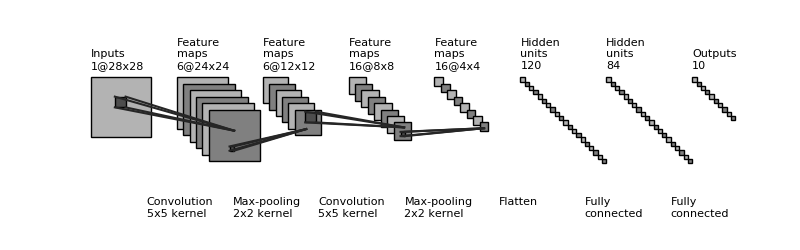

In [99]:
import os
plt.rcdefaults()
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle


NumConvMax = 8
NumFcMax = 20
White = 1.
Light = 0.7
Medium = 0.5
Dark = 0.3
Darker = 0.15
Black = 0.


def add_layer(patches, colors, size=24, num=5,
              top_left=[0, 0],
              loc_diff=[3, -3],
              ):
    # add a rectangle
    top_left = np.array(top_left)
    loc_diff = np.array(loc_diff)
    loc_start = top_left - np.array([0, size])
    for ind in range(num):
        patches.append(Rectangle(loc_start + ind * loc_diff, size, size))
        if ind % 2:
            colors.append(Medium)
        else:
            colors.append(Light)


def add_mapping(patches, colors, start_ratio, patch_size, ind_bgn,
                top_left_list, loc_diff_list, num_show_list, size_list):

    start_loc = top_left_list[ind_bgn] \
        + (num_show_list[ind_bgn] - 1) * np.array(loc_diff_list[ind_bgn]) \
        + np.array([start_ratio[0] * size_list[ind_bgn],
                    -start_ratio[1] * size_list[ind_bgn]])

    end_loc = top_left_list[ind_bgn + 1] \
        + (num_show_list[ind_bgn + 1] - 1) \
        * np.array(loc_diff_list[ind_bgn + 1]) \
        + np.array([(start_ratio[0] + .5 * patch_size / size_list[ind_bgn]) *
                    size_list[ind_bgn + 1],
                    -(start_ratio[1] - .5 * patch_size / size_list[ind_bgn]) *
                    size_list[ind_bgn + 1]])

    patches.append(Rectangle(start_loc, patch_size, patch_size))
    colors.append(Dark)
    patches.append(Line2D([start_loc[0], end_loc[0]],
                          [start_loc[1], end_loc[1]]))
    colors.append(Darker)
    patches.append(Line2D([start_loc[0] + patch_size, end_loc[0]],
                          [start_loc[1], end_loc[1]]))
    colors.append(Darker)
    patches.append(Line2D([start_loc[0], end_loc[0]],
                          [start_loc[1] + patch_size, end_loc[1]]))
    colors.append(Darker)
    patches.append(Line2D([start_loc[0] + patch_size, end_loc[0]],
                          [start_loc[1] + patch_size, end_loc[1]]))
    colors.append(Darker)



def label(xy, text, xy_off=[0, 4]):
    plt.text(xy[0] + xy_off[0], xy[1] + xy_off[1], text,
             family='sans-serif', size=8)


if __name__ == '__main__':

    fc_unit_size = 2
    layer_width = 40

    patches = []
    colors = []

    fig, ax = plt.subplots()


    ############################
    # conv layers
    size_list = [28, 24, 12, 8, 4]
    num_list = [1, 6, 6, 16, 16]
    x_diff_list = [0, layer_width, layer_width, layer_width, layer_width]
    text_list = ['Inputs'] + ['Feature\nmaps'] * (len(size_list) - 1)
    loc_diff_list = [[3, -3]] * len(size_list)

    num_show_list = list(map(min, num_list, [NumConvMax] * len(num_list)))
    top_left_list = np.c_[np.cumsum(x_diff_list), np.zeros(len(x_diff_list))]

    for ind in range(len(size_list)):
        add_layer(patches, colors, size=size_list[ind],
                  num=num_show_list[ind],
                  top_left=top_left_list[ind], loc_diff=loc_diff_list[ind])
        label(top_left_list[ind], text_list[ind] + '\n{}@{}x{}'.format(
            num_list[ind], size_list[ind], size_list[ind]))


    ############################
    # in between layers
    start_ratio_list = [[0.4, 0.5], [0.4, 0.8], [0.4, 0.5], [0.4, 0.8]]
    patch_size_list = [5, 2, 5, 2]
    ind_bgn_list = range(len(patch_size_list))
    text_list = ['Convolution', 'Max-pooling', 'Convolution', 'Max-pooling']

    for ind in range(len(patch_size_list)):
        add_mapping(patches, colors, start_ratio_list[ind],
                    patch_size_list[ind], ind,
                    top_left_list, loc_diff_list, num_show_list, size_list)
        label(top_left_list[ind], text_list[ind] + '\n{}x{} kernel'.format(
            patch_size_list[ind], patch_size_list[ind]), xy_off=[26, -65])


    ############################
    # fully connected layers
    size_list = [fc_unit_size, fc_unit_size, fc_unit_size]
    num_list = [120, 84, 10]
    num_show_list = list(map(min, num_list, [NumFcMax] * len(num_list)))
    x_diff_list = [sum(x_diff_list) + layer_width, layer_width, layer_width]
    top_left_list = np.c_[np.cumsum(x_diff_list), np.zeros(len(x_diff_list))]
    loc_diff_list = [[fc_unit_size, -fc_unit_size]] * len(top_left_list)
    text_list = ['Hidden\nunits'] * (len(size_list) - 1) + ['Outputs']

    for ind in range(len(size_list)):
        add_layer(patches, colors, size=size_list[ind], num=num_show_list[ind],
                  top_left=top_left_list[ind], loc_diff=loc_diff_list[ind])
        label(top_left_list[ind], text_list[ind] + '\n{}'.format(
            num_list[ind]))

    text_list = ['Flatten\n', 'Fully\nconnected', 'Fully\nconnected']

    for ind in range(len(size_list)):
        label(top_left_list[ind], text_list[ind], xy_off=[-10, -65])

    ############################
    for patch, color in zip(patches, colors):
        patch.set_color(color * np.ones(3))
        if isinstance(patch, Line2D):
            ax.add_line(patch)
        else:
            patch.set_edgecolor(Black * np.ones(3))
            ax.add_patch(patch)

    plt.tight_layout()
    plt.axis('equal')
    plt.axis('off')
    plt.show()
    fig.set_size_inches(8, 2.5)

#### Now let's look at the # of operations

<IPython.core.display.Javascript object>


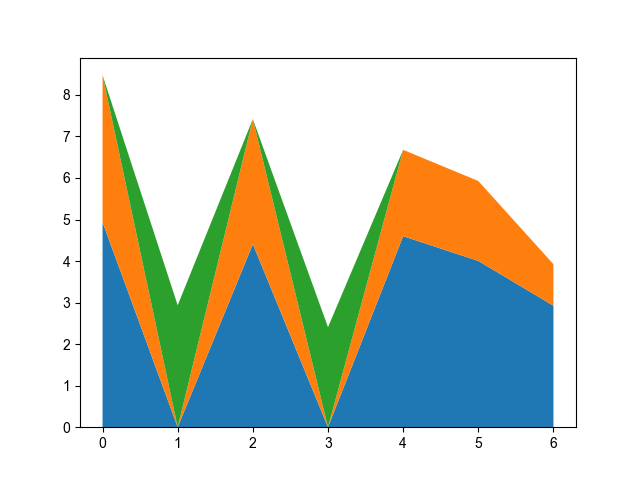

In [105]:
num_mult = np.log10([86400, 1, 25600, 1, 39720, 10080, 840])
num_addition = np.log10([3456, 1, 1024, 1, 120, 84, 10])
num_max = np.log10([1, 864, 1, 256, 1, 1, 1])

y = np.row_stack((num_mult, num_addition, num_max))
x = np.arange(len(num_mult))

fig, ax = plt.subplots()
ax.stackplot(x, y)
plt.show()

<IPython.core.display.Javascript object>


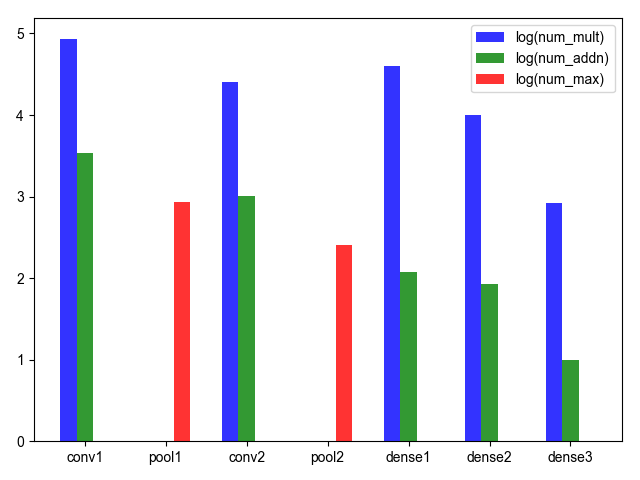

In [107]:
n_groups = 7
 
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.20
opacity = 0.8
 
rects1 = plt.bar(index, num_mult, bar_width,
                 alpha=opacity,
                 color='b',
                 label='log(num_mult)')
 
rects2 = plt.bar(index + bar_width, num_addition, bar_width,
                 alpha=opacity,
                 color='g',
                 label='log(num_addn)')

rects3 = plt.bar(index + bar_width*2, num_max, bar_width,
                 alpha=opacity,
                 color='r',
                 label='log(num_max)')


plt.xticks(index+bar_width, ['conv1','pool1','conv2', 'pool2', 'dense1', 'dense2', 'dense3']);
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


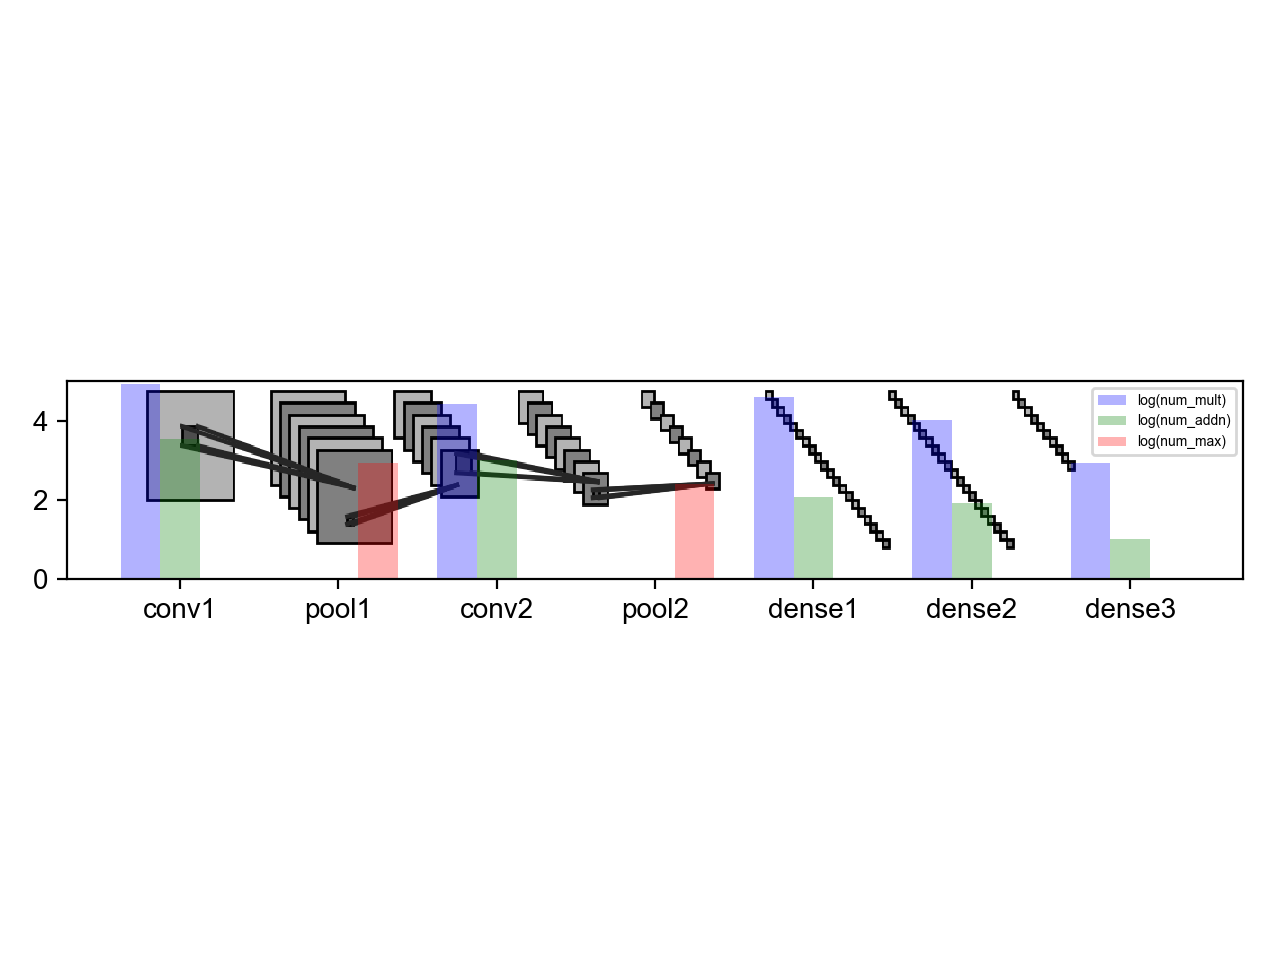

In [120]:
fig, ax = plt.subplots()
img = plt.imread("/Users/thomasboser/Documents/NIPS-2017/lenet-architecture.png")
ax.imshow(img, extent=[0, 24, 0, 5])

n_groups = 7
index = np.arange(n_groups)
bar_width = 1
opacity = 0.3
 
rects1 = plt.bar(index*4, num_mult, bar_width,
                 alpha=opacity,
                 color='b',
                 label='log(num_mult)')
 
rects2 = plt.bar(index*4 + bar_width, num_addition, bar_width,
                 alpha=opacity,
                 color='g',
                 label='log(num_addn)')

rects3 = plt.bar(index*4 + bar_width*2, num_max, bar_width,
                 alpha=opacity,
                 color='r',
                 label='log(num_max)')


plt.xticks(index*4 + bar_width, ['conv1','pool1','conv2', 'pool2', 'dense1', 'dense2', 'dense3']);
plt.legend(loc='upper right', prop={'size': 5})
plt.tight_layout()

plt.show()

#### Let's add the #of resource used and the #of cycles for each layer
I'm not going to try and calculate any real values for this, but it's worth considering that the #mults/addn/maxops in the bar graph above are correct (for this CNN architecture).

<IPython.core.display.Javascript object>


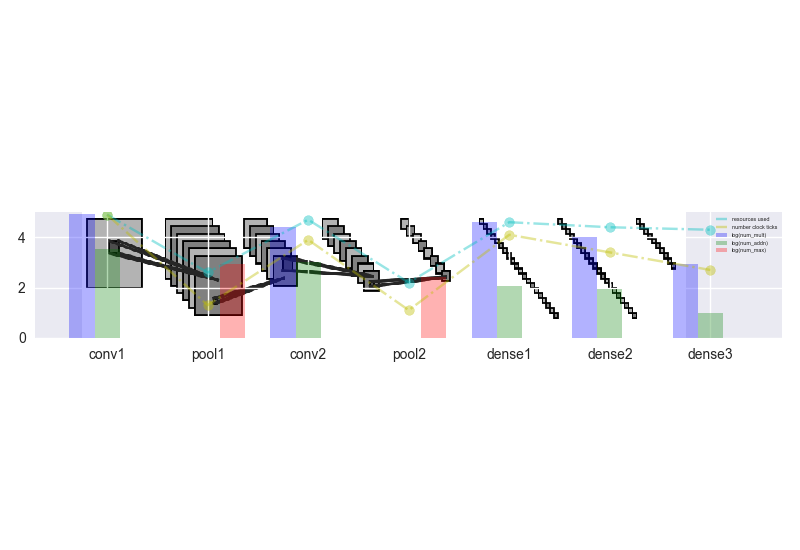

In [139]:
fig, ax = plt.subplots()
img = plt.imread("/Users/thomasboser/Documents/NIPS-2017/lenet-architecture.png")
ax.imshow(img, extent=[0, 24, 0, 5])

n_groups = 7
index = np.arange(n_groups)*4
bar_width = 1
opacity = 0.3
 
rects1 = plt.bar(index, num_mult, bar_width,
                 alpha=opacity,
                 color='b',
                 label='log(num_mult)')
 
rects2 = plt.bar(index + bar_width, num_addition, bar_width,
                 alpha=opacity,
                 color='g',
                 label='log(num_addn)')

rects3 = plt.bar(index + bar_width*2, num_max, bar_width,
                 alpha=opacity,
                 color='r',
                 label='log(num_max)')

resource_usage = [4.9, 2.6, 4.7, 2.2, 4.6, 4.4, 4.3]
clock_cycles = [4.9, 1.3, 3.9, 1.1, 4.1, 3.4, 2.7]

plt.scatter(index+bar_width, resource_usage, c='c', alpha=0.4)
plt.scatter(index+bar_width, clock_cycles, c='y', alpha=0.4)
plt.plot(index+bar_width, resource_usage, '-.', c='c', alpha=0.4, label='resources used')
plt.plot(index+bar_width, clock_cycles, '-.', c='y', alpha=0.4, label='number clock ticks')

plt.xticks(index + bar_width, ['conv1','pool1','conv2', 'pool2', 'dense1', 'dense2', 'dense3']);
plt.legend(loc='upper right', prop={'size': 4})
plt.tight_layout()

plt.show()

#### Resources, latency, and CNNs
The plot above may be a bit too much to stomach.  
I'll move on to exploring some plots which describe resource usage vs #clock cycles vs width of CNN.  
I'll assume the relationship between clock cycles and resources/CNN width is:  
\#clock cycles = size of CNN / \#resources used  

<IPython.core.display.Javascript object>


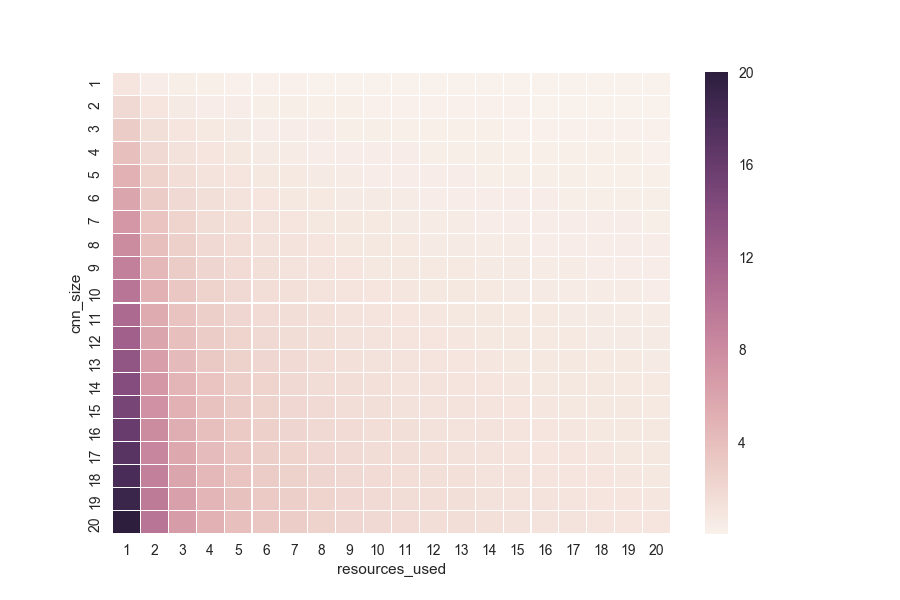

In [153]:
import seaborn as sns
import pandas as pd
d = {'cnn_size':[], 'resources_used':[], 'clock_cycles':[]}
for i in range(1, 21):
    for j in range(1, 21):
        d['cnn_size'].append(i)
        d['resources_used'].append(j)
        d['clock_cycles'].append(float(i)/float(j))
dataset = pd.DataFrame(d).pivot('cnn_size', 'resources_used', 'clock_cycles')
sns.set()
fig, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(dataset, linewidths=.02, ax=ax)
plt.show()